# CS-E4895: Gaussian Processes

## Assignment #5: Sparse Variational GPs and State Space GP Regression

### Learning objectives

After completing the exercise, you should be able to:
- Learn to implement the Sparse Variational GP ELBO function and its whitened version.
- Learn about state-space GPs and the computational benefits they can offer

This assignment is worth 6 points. It has two tasks, which are each worth 3 points.

## Enter your student number

**STUDENT_NUMBER** = 103198246

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

In [3]:
%matplotlib inline
import os
import math
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.linalg as linalg

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

2025-04-03 04:46:14.972315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
automatic_grading = False  # Set this to True after completing the notebook and before submitting.

### Do not move or delete the below block. It is used for automatic grading.

## Task 1: Sparse variational GPs & Whitening (3 points)

In this task, we implement the sparse GP version of the GP classification task in the previous assignment. Sparse GPs allow us to scale the GP inference to much larger data sets by using *inducing points*. We will use the same data set as last time, but this time the full version with >5000 data points. This would be very computationally demanding with the non-sparse approach. 

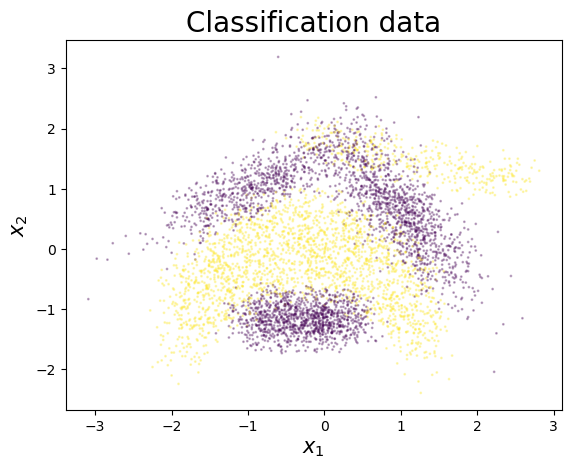

In [5]:
# Loading the data
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)

XY = np.array(XY)
X = XY[:,:2]
Y = (XY[:,2:3]-1.5) * 2 # to be in {-1, 1}
N = XY.shape[0]

# Plotting the data
plt.scatter(X[:,0], X[:,1], c=Y, s=1, alpha=0.3)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

**Task 1a:** Copy and paste the implementations for the functions below from previous assignments (Hint: The correct solutions are also posted into the course Zulip).

In [6]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N × 1, mean vector
    L0, L1   -- N × N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    # YOUR CODE HERE
    term1 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, L0)))
    term2 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, (m1 - m0))))
    k = tf.cast(tf.shape(L0)[0], tf.float64)
    term3inner = tf.math.log(tf.abs(tf.linalg.diag_part(L1))) - tf.math.log(tf.abs(tf.linalg.diag_part(L0)))
    return 0.5*(term1 + term2 - k + 2.0 * tf.reduce_sum(term3inner))
    #raise NotImplementedError()

def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    arguments:
    m   -- N × 1, mean vector
    L   -- N × N, Cholesky factor of a covariance matrix 
    returns two N × 1 vectors
    """
    # YOUR CODE HERE
    v = tf.reshape(tf.linalg.diag_part(tf.matmul(L, L, transpose_b=True)), (-1, 1))
    return m, v
    #raise NotImplementedError()

def phi(x):
    r""" Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)
    Hint 2: You may want to use a small epsilon parameter to ensure that the output 
            is strictly between 0 and 1

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    # YOUR CODE HERE
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter

    #raise NotImplementedError()


def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
        
    Arguments:
    f -- The GP value at the observation
    y -- The observed value of y, either -1 or 1
    """
    # YOUR CODE HERE
    return tf.math.log(phi(y * f))
    #raise NotImplementedError()


def expected_log_likelihood(means, mvars, llh, y, n_gh=20):
    """ returns the expected log likelihood terms
    
    E_q(f_n)[log p(y_n|f_n)]
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N × 1, vector of means
    mvars  -- N × 1, vector of marginal variances
    llh    -- log likelihood function
    y      -- N × 1, vector of observed labels
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 × n_gh
    inputs = means + np.sqrt(2) * tf.sqrt(mvars) * z.reshape(1, -1) # N × n_gh
    llh_quad = weights * llh(inputs, y) # N × n_gh

    return tf.reduce_sum(llh_quad, axis=1) # N,

def kernelmatrix(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    # YOUR CODE HERE
    dist = tf.reduce_sum((X1[:, None, :] - X2[None, :, :])**2, axis=-1)
    return sigma_squared * tf.exp(- dist / (2*ell**2))

    raise NotImplementedError()

def posterior_marginal_prediction(X_new, X, m_q, L_q, log_ell, log_sigma_squared):
    """ compute the posterior marginal predictions q(f(x*)) 
    independently for all inputs in X_new 
    
    !!! IMPORTANT !!!
    We should avoid computing the full N_new × N_new covariance matrix due to memory limitations.
    You only need the diagonal values of this matrix for the predictive variances.
    Could you implement an alternative to kernelmatrix() to do this?

    !!! NEW IMPORTANT NOTE !!!
    Last time you may have gotten this to work without using tensorflow functions. 
    Now you really need them because we are going to calculate gradients through this function
    
    arguments:
    X_new -- N_new × 2, matrix of new inputs
    X     -- N × 2, matrix of training inputs
    m_q   -- N × 1, mean vector of q
    L_q   -- N × N, Cholesky factor of the covariances of q
    log_ell -- log-length-scale of the kernel
    log_sigmasquared -- log-variance of the kernel
    
    returns: predictive marginal means and variances (both with size N_new × 1)
    """

    # YOUR CODE HERE
    def kernelmatrix_diag(X, log_sigma_squared):
       sigma_squared = tf.exp(log_sigma_squared)
       return sigma_squared * np.ones((len(X), 1))

    Kfs = kernelmatrix(X, X_new, log_ell, log_sigma_squared)
    Kff = kernelmatrix(X, X, log_ell, log_sigma_squared)
    Kss = kernelmatrix_diag(X_new, log_sigma_squared)

    KffInv_Kfs = tf.linalg.solve(Kff, Kfs)
    m_new = tf.matmul(KffInv_Kfs, m_q, transpose_a=True)
    S = tf.matmul(L_q, L_q, transpose_b=True)

    v_new = Kss - tf.reduce_sum(KffInv_Kfs * ((Kff - S) @ KffInv_Kfs), axis=0)[:, None]
    return m_new, v_new
    #raise NotImplementedError()

### Sparse GP ELBO
To evaluate the variational expectations (data fit) term of the SVGP objective, you need the marginals of $q({\bf f})$ - think about how you can re-use `posterior_marginal_prediction` for that.

**Task 1b:** Implement the ELBO for a SVGP

In [15]:
def sparse_gp_elbo(m_p, L_p, m_q, L_q, Z, X, y, log_ell, log_sigma_squared):
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(u)∥p(u)]
    
    (See slides of lecture 5 and 6 for closed-form solution)
    
    arguments:
    L_p, L_q  -- N × N, Cholesky factors of the covariances of p and q MxM
    m_p, m_q  -- N × 1, mean vector of p and q Mx1
    Z, X      -- N × D, inducing points and training points Z - MxD, X - NxD
    y         -- N × 1, training observations Y Nx1
    log_ell   -- log length scale
    log_sigma_squared -- log kernel variance
    
    returns: a scalar
    """    
    # YOUR CODE HERE
    pred_means, pred_vars = posterior_marginal_prediction(
        X_new=X, 
        X=Z, 
        m_q=m_q, 
        L_q=L_q, 
        log_ell=log_ell, 
        log_sigma_squared=log_sigma_squared
    )
    
    # Compute expected log likelihood using the marginals
    ell_terms = expected_log_likelihood(
        means=pred_means,
        mvars=pred_vars,
        llh=classif_log_likelihood,
        y=y
    )
    
    # Compute KL divergence between q(u) and p(u)
    kl_term = KL(m_q, L_q, m_p, L_p)
    
    # ELBO = sum of expected log likelihoods - KL divergence
    return tf.reduce_sum(ell_terms) - kl_term
    raise NotImplementedError()

Let's test the above function

In [18]:
test_n = 3
test_z = 2
test_mp = np.asarray([[0.0], [0.0]]).reshape((test_z, 1))
test_Lp = np.eye(test_z)
test_mq = np.asarray([[1.0], [1.0]]).reshape((test_z, 1))
test_Lq = np.tril(np.arange(test_z * test_z).reshape(test_z, test_z) / 10) + 10 * np.eye(test_z)
test_X = np.asarray([[-1.0, 1.0, 0.5]]).reshape((test_n, 1))
test_y = np.ones((test_n, 1), dtype=test_X.dtype)
test_Z = np.asarray([[1.0, 2.0]]).reshape((test_z, 1))

test_log_ell = tf.convert_to_tensor(np.math.log(1), dtype=test_mp.dtype)
test_log_sigma_squared = tf.convert_to_tensor(np.math.log(2.0), dtype=test_mp.dtype)

# This assertion should pass if your implementation is correct
assert np.allclose(sparse_gp_elbo(test_mp, test_Lp, test_mq, test_Lq, test_Z, test_X, test_y, test_log_ell, test_log_sigma_squared).numpy(), -106.5484, atol=1e-2, rtol=1e-2)


In [19]:
# Define some dummy data
test_n = 2
test_mp = np.asarray([[0.0], [0.0]])
test_Lp = np.eye(test_n)
test_mq = np.asarray([[1.0], [1.0]])
test_Lq = np.tril(np.arange(test_n * test_n).reshape(test_n, test_n) / 10) + 10 * np.eye(test_n)
test_y = np.ones_like(test_mp)
test_X = np.asarray([[-1.0, 1.0]])
test_Z = np.asarray([[1.0, 2.0], [-1.0, -2.0]])

test_log_ell = tf.convert_to_tensor(np.math.log(1), dtype=test_mp.dtype)
test_log_sigma_squared = tf.convert_to_tensor(np.math.log(2.0), dtype=test_mp.dtype)

# This assertion should pass if your implementation is correct
assert np.allclose(sparse_gp_elbo(test_mp, test_Lp, test_mq, test_Lq, test_Z, test_X, test_y, test_log_ell, test_log_sigma_squared).numpy(), -101.03, atol=1e-2, rtol=1e-2)

#### Do not move or delete the below block. It is used for automatic grading.

### Whitened sparse GP ELBO
In the code below, let's also implement 'whitening': Instead of parametrizing the Cholesky factor of the posterior covariance directly, we define a new variable $\mathbf v$ such that $\mathbf u = \mathbf L_p \mathbf v + \mathbf m_p$, where $\mathbf u$ are the inducing variables. The reason is that the optimization pushes $q(\mathbf u)$ to be similar to $p(\mathbf u)$, and thus the elements in $\mathbf L_q$ are strongly correlated. This makes optimization more difficult. In contrast, the distribution of $\mathbf v$ that corresponds to the prior is $\mathcal N(\mathbf 0, \mathbf I)$. Thus, we define our optimized variables as $\mathbf m', \mathbf S'$ in $q(\mathbf v) = \mathcal N(\mathbf m', \mathbf S')$ and transform them back to $\mathbf u$-space using $L_p, m_p$ whenever we need to do ELBO calculations or calculate conditional distributions. When we do this, $\mathbf m'$ and $\mathbf S'$ are much easier to optimize than directly defining them as the mean and covariance of the real posterior $q(\mathbf u)$.

See also lecture 7.

**Task 1c:** Implement the unwhitening and the whitened SVGP ELBO functions below.

In [ ]:
def unwhiten(m_p, L_p, m_qv, L_qv):
    """Transformation from the whitened distribution q(v) to unwhitened distribution q(u)
    arguments:
    L_p, L_qv  -- N × N, Cholesky factors of the covariances of p and the whitened q
    m_p, m_qv  -- N × 1, mean vector of p and the whitened q
    returns:
    m_qu       -- N × 1 unwhitened mean vector and NxN
    L_qu       -- N x N Cholesky factor of the unwhitened covariance
    """
    # YOUR CODE HERE
    raise NotImplementedError()

def sparse_gp_elbo_whitened(m_p, L_p, m_qv, L_qv, Z, X, y, log_ell, log_sigma_squared):
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(v)∥p(v)]

    (See slides of lecture 5 and 6 for closed-form solution)
    
    arguments:
    L_p, L_qv  -- N × N, Cholesky factors of the covariances of p and the whitened q
    m_p, m_qv  -- N × 1, mean vector of p and the whitened q
    Z, X      -- N × D, inducing points and training points
    y         -- N × 1, training observations
    returns: a scalar
    """
    # YOUR CODE HERE
    raise NotImplementedError()

Lets test the above functions

In [ ]:
# Define some dummy data
test_n = 2
test_mp = np.asarray([[0.1], [0.2]])
test_Lp = np.eye(test_n)
test_mq = np.asarray([[0.3], [0.4]])
test_Lq = np.tril(np.arange(test_n * test_n).reshape(test_n, test_n) / 10) + 10 * np.eye(test_n)

test_mqu, test_Lqu = unwhiten(test_mp, test_Lp, test_mq, test_Lq)
assert np.allclose(test_mqu.flatten(), np.asarray([0.4, 0.6]))
assert np.allclose(test_Lqu.numpy().flatten(), np.asarray([10.0, 0.0, 0.2, 10.3]), atol=1e-2, rtol=1e-2)

#### Do not move or delete the below block. It is used for automatic grading.

### Running the optimisation
Use the following code to run the variational inference optimisation loop. Get to know the code, and answer the multiple choice questions about it.

Let's not optimise the hyperparameters of $q$ now for simplicity. If you like, you can try modifying the code to also optimise them.

**Task 1d:** Copy-paste your solution from **Assignment 4: Task 2b** into the function `get_prior_parameters` (Hint: The correct solution is also posted in the course Zulip after the Assignment 4 deadline).

In [ ]:
def optimize_elbo(ell, sigma_squared, optimize_inducing_points=False):
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)

    M = 16
    Z = tf.Variable(X[:M].copy())

    @tf.function
    def get_prior_parameters(z, log_ell, log_sigma_squared):
        # YOUR CODE HERE
        raise NotImplementedError()
        return m_p, L_p 
    
    # The prior mean at the inducing points and the Cholesky factor of the prior covariance, with small diagonal jitter
    m_p, L_p = get_prior_parameters(Z, v_log_ell, v_log_sigma_squared)

    # Inference distributions
    m_qv = tf.Variable(np.zeros((M, 1)), dtype=tf.float64)
    L_qv_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((M,M))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))

    loss_svgp = lambda: - sparse_gp_elbo_whitened(
        m_p, tf.linalg.cholesky(kernelmatrix(Z, Z, v_log_ell, v_log_sigma_squared)+ 1e-10*tf.eye(Z.shape[0],dtype=tf.float64)),
        m_qv, transform(L_qv_params), Z, X, Y, v_log_ell, v_log_sigma_squared)

    ##### definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.1)
    train_step = create_train_step(loss_svgp, opt, [Z, m_qv, L_qv_params]) if optimize_inducing_points \
                                        else create_train_step(loss_svgp, opt, [m_qv, L_qv_params])

    num_iterations = 1100 # you can change the number of steps as well

    # running the optimization
    neg_elbo_values = []
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0:
            print(f"Train step: {t}, Neg. ELBO: {loss_svgp().numpy()}")
    
    return Z, m_qv, transform(L_qv_params), neg_elbo_values, v_log_ell, v_log_sigma_squared

**Task 1d:** How many inducing points are we using in `optimize_elbo`?

**1)** 4

**2)** 8

**3)** 16

**4)** 32

Type your answer in the cell below.

In [ ]:
a_1d = None # TASK: Replace None with your answer (1, 2, 3, 4)

In [ ]:
assert a_1d in [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

**Task 1e:** To what values are the inducing points initialised in `optimize_elbo`?

**1)** A sample from the standard normal distribution

**2)** A sample from a uniform distribution

**3)** Zeros

**4)** A subset of the data points

Type your answer in the cell below.

In [ ]:
a_1e = None  # TASK: Replace None with your answer (1, 2, 3, 4)

In [ ]:
assert a_1e in [1, 2, 3, 4]

#### Do not move or delete the below block. It is used for automatic grading.

### Optimisation with fixed inducing points & plotting results
First, let's try optimising the ELBO only with the mean and covariance of $q(\mathbf u)$, and keep the inducing point locations $\mathbf Z$ fixed at a subset of data points. 

After finding the parameters $\mathbf L_q$ and $\mathbf m_q$, plot the results using the function provided. Note that the optimisation loop returns the whitened $\mathbf L_q$ and $\mathbf m_q$, you will have to take that into account before passing values to the plotting code.

Also copy-paste your solution from last week for the posterior predictive distribution $p(y*=1|y)$ in the plotting code.

In [ ]:
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance

# kernel parameters
if not automatic_grading:

    # Run the optimisation
    Z, m_qv, L_qv, neg_elbo_values, v_log_ell, v_log_sigma_squared = optimize_elbo(ell, sigma_squared, optimize_inducing_points=True)
    
    # Plot optimisation progress
    plt.plot(neg_elbo_values)
    plt.ylabel('negative ELBO')
    plt.xlabel('Steps')
    plt.title('Training step vs. Optimised Negative ELBO Plot')
    plt.show()

**Task 1f:** Copy-paste your solution for computing `y_new` from function `plot_posterior` in **Assignment 4: Task 3c** into the new function for plotting the posterior

In [ ]:
# create new input points on grid
n_grid = 100
x = np.linspace(XY[:,0].min(), XY[:,1].max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

def plot_posterior(Z, m_new, v_new, neg_elbo):
    """
    Plots the posterior prediction for the grid in Xnew (global variable)
    
    arguments:
    m_new -- mean at Xnew
    v_new -- variance at Xnew
    neg_elbo -- negative elbo value from optimization
    """
    y_new = ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
    plt.figure(figsize=(12,4))
    plt.suptitle(f"ELBO: {-neg_elbo : .2f}")
    plt.subplot(1,3,1)
    plt.contour(x, x, m_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=-np.abs(m_new).max(), vmax=np.abs(m_new).max())
    plt.colorbar()
    plt.title("Posterior mean")
    plt.subplot(1,3,2)
    plt.contour(x, x, v_new.numpy().reshape(n_grid,n_grid))
    plt.colorbar()
    plt.title("Posterior variance")
    plt.subplot(1,3,3)
    plt.scatter(Z[:,0], Z[:,1], color='black') # Inducing points
    plt.legend(["Inducing points"])
    plt.contour(x, x, y_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=0, vmax=1)
    plt.colorbar()
    plt.title("p(y|f)")

    plt.scatter(X[:,0], X[:,1], c=Y, s=1, alpha=0.3)  # all data points
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())

**Task 1g**: Complete the function for computing the posterior predictive mean `m_new` and variance `v_new` and plot the results. The final plot should resemble the plot below:

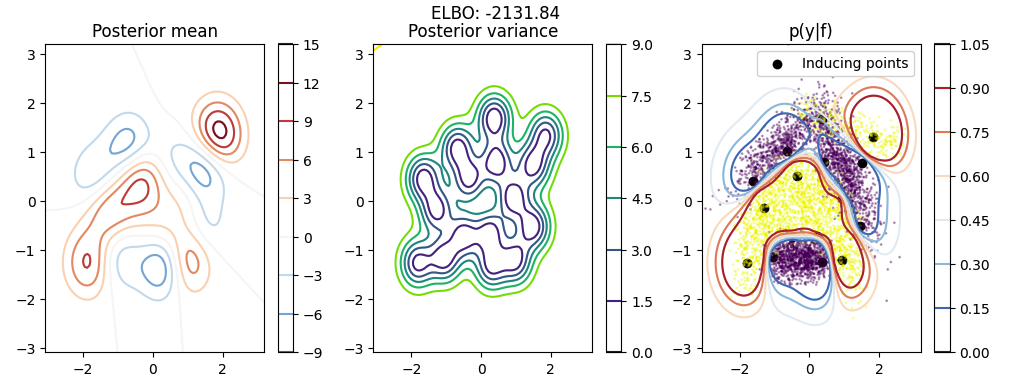

In [ ]:
# Note: The m_qv and L_qv are whitened posterior parameters
def get_posterior_predictive_params(x_new, z, m_qv, L_qv, v_log_ell, v_log_sigma_squared):
    """
    
    arguments:
        x_new -- N x D matrix of new data points
        z     -- M x D matrix of inducing points
        m_qv  -- M × 1, mean vector of the whitened q
        L_qv  -- M × M, Cholesky factor of the covariances of the whitened q

    returns:
        m_new, v_new; predictive marginal means and variances (both with size N_new × 1)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

    return m_new, v_new

Let's test the above function

In [ ]:
# Initializing some dummy data
test_Z = np.asarray([[1.0, 2.0], [3.0, 4.0]])
test_n = test_Z.shape[0]
test_X_new = np.linspace(0, 1, 4).reshape(2, 2)
test_mqv = np.arange(test_n).reshape(-1,1)
test_Lqv = np.tril(np.arange(test_n * test_n).reshape(test_n, test_n) / 10) + 10 * np.eye(test_n)

# Calling your function
test_m, test_v = get_posterior_predictive_params(test_X_new, test_Z, test_mqv, test_Lqv, test_log_ell, test_log_sigma_squared)

assert np.allclose(test_m.numpy(), np.asarray([[-0.00389919],[-0.01383118]]), rtol=1e-2, atol=1e-2)
assert np.allclose(test_v.numpy(), np.asarray([[6.5272085], [67.15543209]]), rtol=1e-2, atol=1e-2)

Finally, plot the results

In [ ]:
if not automatic_grading:
    m_new, v_new = get_posterior_predictive_params(Xnew, Z, m_qv, L_qv, v_log_ell, v_log_sigma_squared)
    plot_posterior(Z, m_new, v_new, neg_elbo_values[-1])

#### Do not move or delete the below block. It is used for automatic grading.

### Optional: Advanced extra questions on variational inference, VGPs and sparse VGPs (only for the curious, **no extra points!**)
* For fixed hyperparameters, does the ELBO match the marginal likelihood $\log p({\bf y})$? If so, why & when?
* How does the ELBO-at-optimum change as you vary the number of inducing points?
* Repeat the procedure for the regression setting with Gaussian noise. You need to derive new variational expectations since the likelihood changes. Apply the resulting algorithm to the regression problem of the previous assignment.
* Jointly optimise the kernel hyperparameters in addition to the inducing points $Z$, and $q({\bf u})$. How does the optimal value of the kernel hyperparameters depend on the number of inducing points?


---



## Task 2: State-space GP regression (3 points)
1. In this exercise you start by first creating some dummy data by simulating a random function from a Matern $\nu=\frac{3}{2}$ (nu) GP prior and then adding some Gaussian observation noise. 
2. The next step is to solve a GP regression task in order to recover the unknown latent function. This is done naively in the standard way by expanding the covariance matrix and inverting it (even though here we use the Cholesky factor to some additional stability, but still just using numpy). 
3. Finally the exactly same inference problem is solved sequentially by state space inference methods, and you are supposed to recover the _exactly_ same solution (within numerical precision), but now in $O(n)$ time complexity rather than $O(n^3)$.

Run the code (you will need to modify it in the next tasks). Feel free to experiment with the hyperparameters (magnitude, characteristic length-scale, and noise scale), and the number of data points, n. The larger your n, the larger the time difference between the two approaches.

### Part 1: Simulating some dummy data

Run the code below to create some simulated data.

In [ ]:
# Parameters
n = 1000
sigma2 = 1
magnSigma2 = 1
ell = 1

In [ ]:
# Observation time indices
t = np.linspace(0,10,n).reshape((n,1))

# Set up kernel (Matern nu=3/2)
tx,ty=np.meshgrid(t,t);
D = abs(tx-ty)
K = magnSigma2 * (1 + np.sqrt(3)*D/ell) * np.exp(-np.sqrt(3)*D/ell)

# Draw a random sample from the GP prior
np.random.seed(43)
L = np.linalg.cholesky(K)
f = L.dot(np.random.randn(n))
y = f + np.sqrt(sigma2)*np.random.randn(n)

plt.figure(figsize=(12, 6))
plt.plot(t, f, 'k-', label=u'Hidden $f(t)$')
plt.plot(t, y, 'r+', markersize=5, label=u'Observations')
plt.xlabel('Input, $t$')
plt.ylabel('Output, $y$')
plt.title('Generated data from GP Prior')
plt.legend()

### Part 2: Naive GP approach

Run the code below and observe how long it takes to run.

In [ ]:
# Helper function for plotting results
def plot_gp(t, f, y, Eft, Varft, marginal):
    plt.figure(figsize=(12, 6))
    plt.plot(t, f, 'k-', label=u'Hidden $f(t)$')
    plt.plot(t, y, 'r+', markersize=5, label=u'Observations')
    plt.plot(t, Eft, 'b-', label=u'Posterior mean')

    plt.fill(np.concatenate([t, t[::-1]]),
             np.concatenate([Eft - 1.96 * np.sqrt(Varft),
                            (Eft + 1.96 * np.sqrt(Varft))[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('Input, $t$')
    plt.ylabel('Output, $y$')
    plt.title('Marginal LLH: {0}'.format(marginal))
    plt.legend()

def naive_gp_regression(y, K, sigma2):
    """ 
    Naive implementation of GP regression
    """
    n = len(y)

    # Solve the GP regression problem the naive way
    alpha = np.linalg.solve(K+sigma2*np.eye(n), y)
    L = np.linalg.cholesky(K+sigma2*np.eye(n))
    v = np.linalg.solve(L, K)
    Eft = K.dot(alpha) # Posterior mean
    Varft = np.diag(K) - np.sum(v**2,axis=0) # Marginal variance

    # Negative log marginal likelihood
    negloglik = n/2*np.log(2*np.pi) + np.sum(np.log(np.diag(L))) + .5*y.T.dot(np.linalg.inv(K+sigma2*np.eye(n))).dot(y) #.5*y.T.dot(alpha)

    return Eft, Varft, negloglik

if not automatic_grading:
    # Start timing
    start = time.process_time() 

    # Perform GP regression naively
    Eft, Varft, negloglik = naive_gp_regression(y, K, sigma2)

    # End timing (this should grow O(n^3))
    end = time.process_time()
    print("Naive GP inference took %.3f s." % (end - start)) 

    # Plot GP
    plot_gp(t, f, y, Eft, Varft, negloglik)

### State space approach
**Task 2a**: Implement the function `kalman_negloglik_update` that is used in the Kalman filter for evaluating the negative log marginal likelihood during the forward sweep. This quantity has to do with the so called innovation mean `v` and variance `s`. If you feel confused, look at the material in the lecture slides, or the two papers mentioned as pre-reading.

In [ ]:
def kalman_negloglik_update(s, v):
    """
    Computes the Kalman Filter update to the negative log likelihood
    
    arguments:
        v -- innovation mean
        s -- innotation variance

    returns: a scalar
    """
    # == 
    # Task 2a:
    # Compute the marginal likelihood
    # ==
    # YOUR CODE HERE
    raise NotImplementedError()

Let's test the above function

In [ ]:
test_s = np.asarray([[1.0]])
test_v = np.asarray([2.0])

assert np.allclose(kalman_negloglik_update(test_s, test_v), 2.919, rtol=1e-2, atol=1e-2)

In [ ]:
# Kalman filter (forward pass)
def kalman_filter(y, h, M, P, Q, A, sigma2):
    negloglik = 0
    for i in range(0,y.shape[0]):
        # Prediction step
        if i > 0:
            M[:,i] = A.dot(M[:,i-1])
            P[:,:,i] = A.dot(P[:,:,i-1]).dot(A.T) + Q
    
        # Update step
        v = y[i]-h.T.dot(M[:,i])
        s = h.T.dot(P[:,:,i]).dot(h) + sigma2
        k = P[:,:,i].dot(h) / s
        M[:,i] += k.dot(v)
        P[:,:,i] -= k.dot(h.T).dot(P[:,:,i])
    
        # Update log likelihood
        negloglik += kalman_negloglik_update(s, v) # Implement this!

    return M, P, negloglik

# Rauch-Tung-Striebel smoother (backward pass)
def rauch_tung_striebel_smoother(y, h, M, P, Q, A):
    Eft = np.zeros(y.shape[0])
    Varft = np.zeros(y.shape[0])
    
    for i in range(y.shape[0]-2,-1,-1):
        Pp = A.dot(P[:,:,i]).dot(A.T) + Q
        G = np.linalg.solve(Pp, (P[:,:,i].dot(A.T)).T).T
        M[:,i] += G.dot(M[:,i+1]-A.dot(M[:,i]))
        P[:,:,i] += G.dot(P[:,:,i+1]-Pp).dot(G.T)

        Eft[i] = h.T.dot(M[:,i])
        Varft[i] = h.T.dot(P[:,:,i]).dot(h)

    return M, P, Eft, Varft

In [ ]:
# Define continuous-time state space model (SDE):
lam = np.sqrt(3)/ell;
F = np.array([[0,1],[-lam**2,-2*lam]])
Pinf = np.array([[magnSigma2,0],[0,magnSigma2*lam**2]])
h = np.array([[1],[0]])

# Solve the SDE for discrete time steps:
# The resulting state transition matrix and process noise covariance
dt = t[1]-t[0]
A = linalg.expm(F*dt)
Q = Pinf - A.dot(Pinf).dot(A.T)

# State mean and covariance
M = np.zeros((F.shape[0],n))
P = np.zeros((F.shape[0],F.shape[0],n))
P[:,:,0] = Pinf

if not automatic_grading:
    # Start timing
    start = time.process_time()

    # Apply the state-space approach
    M, P, negloglik = kalman_filter(y, h, M, P, Q, A, sigma2)
    M, P, Eft, Varft = rauch_tung_striebel_smoother(y, h, M, P, Q, A)

    # End timing (this should grow O(n))
    end = time.process_time()
    print("State space inference took %.3f s." % (end - start)) 
    
    # Plot GP
    plot_gp(t,f,y,Eft,Varft,negloglik)

#### Do not move or delete the below block. It is used for automatic grading.

## State space GPs with the exponential kernel

Copy-over the code from above and modify the GP prior to use the exponential kernel instead of the Matern $\nu=\frac{3}{2}$. This means that you need to define the covariance function and define the matrices `F = -1/ell`, `h = 1`, and `Pinf = magnSigma2`. This stochastic differential equation is known as the Ornestein-Uhlenbeck process (see, e.g., discussion in Rasmussen and Williams, 2006, Appendix B).
After changing the model, make sure that you still get the same solution both ways.

**Task 2b**: Implement the exponential kernel and compute the kernel matrix $K$

In [ ]:
def exp_kernel(tx, ty, lam, magnSigma2):
    """
    The exponential kernel function
    
    arguments:
        tx -- NxN matrix (from np.meshgrid)
        ty -- NxN matrix (from np.meshgrid)
        lam -- scalar
        magnSigma2 -- scalar

    returns:
        NxN kernel matrix
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return K

Let's test the above function

In [ ]:
test_t = np.linspace(0,10,2).reshape((2,1))
test_tx, test_ty = np.meshgrid(test_t, test_t)
assert np.allclose(exp_kernel(test_tx, test_ty, 0.1, 2.0), np.asarray([[2.00, 0.736],[0.736, 2.00]]), atol=1e-2, rtol=1e-2)

#### Do not move or delete the below block. It is used for automatic grading.

### Naive GP approach

In [ ]:
# Compute the kernel matrix with the exponential kernel
K = exp_kernel(tx, ty, lam, magnSigma2)

# Draw a random sample from the GP prior
np.random.seed(43)
L = np.linalg.cholesky(K)
f = L.dot(np.random.randn(n))
y = f + np.sqrt(sigma2)*np.random.randn(n)

if not automatic_grading:
    # Start timing
    start = time.process_time() 

    # Solve the GP regression problem the naive way
    Eft, Varft, negloglik = naive_gp_regression(y, K, sigma2)

    # End timing (this should grow O(n^3))
    end = time.process_time()
    print("Naive GP inference took %.3f s." % (end - start)) 

    # Plot GP
    plot_gp(t, f, y, Eft, Varft, negloglik)

### State space GP approach

**Task 2c:** Define the matrices `F` and `Pinf`

In [ ]:
F = ...
Pinf = ...
h = np.array([[1]])

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert F.shape == (1,1)

#### Do not move or delete the below block. It is used for automatic grading.

In [ ]:
# Solve the SDE for discrete time steps:
# The resulting state transition matrix and process noise covariance
dt = t[1]-t[0]
A = linalg.expm(F*dt)
Q = Pinf - A.dot(Pinf).dot(A.T)

# State mean and covariance
M = np.zeros((F.shape[0],n))
P = np.zeros((F.shape[0],F.shape[0],n))
P[:,:,0] = Pinf

if not automatic_grading:
    # Start timing
    start = time.process_time()

    M, P, negloglik = kalman_filter(y, h, M, P, Q, A, sigma2)
    M, P, Eft, Varft = rauch_tung_striebel_smoother(y, h, M, P, Q, A)

    # End timing (this should grow O(n))
    end = time.process_time()
    print("State space inference took %.3f s." % (end - start)) 
    
    # Plot GP
    plot_gp(t,f,y,Eft,Varft,negloglik)

**Task 2c:** Do the naive GP implementation and state space GP implementations yield approximately the same result (**True** or **False**)? Type your answer in the cell below.

In [ ]:
a_2c = None # TASK: Replace None with your answer True or False

In [ ]:
assert isinstance(a_2c, bool)

#### Do not move or delete the below block. It is used for automatic grading.

---

### Task 3: After answering all the questions, kindly set `automatic_grading=True` at the top of the notebook, use the validate option in the toolbar to validate the notebook and be sure that there are no errors.

---